# Week 12: Unsupervised Learning (K-means Clustering)

```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


```
In this lab, you will practice Clustering techniques

Lab Plan
1. K-means
2. K-means++
3. Choosing optimal k
```

<hr>


## 1. K-means

<!-- ![](https://habrastorage.org/getpro/habr/upload_files/b29/6a9/6aa/b296a96aa792d2b703095cff04d1fa1b.png) -->
![](https://cdn.prod.website-files.com/62d9f09a3f988192955bafdd/6333e933d59c96b5548b4779_wnPfCqUXLsuOVYDGpnBYdjYVdRZW6isYgWGg6OXK18IgfX7gVaZwkDoy73yuY6Py140VBcGYHidMlAcKkKj3KJqutf-f8v8SUkv8Cj99AlUq40Sn70foc4TEl2EOIFlbWXjzkQhSYqi_8eqyMkyNHEcGedJPLp0AliTUYKbH1rnIts1qG8gyvkP-.png)

K-means is an unsupervised ML technique to cluster unlabeled dataset to k clusters where each datapoint belongs to a cluster with the nearest centroid.

##### Thoughts:
What's the pros and cons of K-means?

<span style="color:blue">
Pros:

1. Scales good with large datasets
2. Guarantees convergence.
3. generalize well with clusters of globular, spherical,or elliptical shapes.

Cons:
1. K has to be chosen manually. (we can use the loss vs the #cluster method)
2. Being dependent on the initial state
3. Not efficient at clustering data with varying densities and sizes.
4. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.
(so we may need to reduce dimensions first)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1.1 Data generation

In [2]:
from sklearn.datasets import make_blobs
import pandas as pd
import plotly.express as px

real_centers = [[1,1], [5,5], [8, 1]]
X, y = make_blobs(n_samples=300, centers=real_centers, n_features=2,
                   random_state=0,)

df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['label'] = y

fig = px.scatter(df, x='Feature 1', y='Feature 2', title='My Unlabeled Data', marginal_x="histogram", marginal_y="histogram")
fig.show()

## 1.2 Implementing K-means method

### Task: implement the fit and predict function of K-means class here.

In [10]:
X.shape

(300, 2)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy


class KMeans(BaseEstimator, ClassifierMixin):

    def __init__(self, k=3, centers=None):
        self.k = k
        self.centers = centers

    def _predict(self, X, centers):
        # (1-2 lines) Calculate the pairwise distance
        # between each sample in X and the centroids.
        distance = cdist(X, centers)
        return np.argmin(distance, axis=1)

    def predict(self, X, y=None):
        return self._predict(X, self.centers)
    
    # we implement this function to update cluster centers
    def fit(self, X, y=None):
        # number of features in our dataset 
        c = X.shape[1]
        if self.centers is None:
            # compute mean and std for each feature 
            mean = np.mean(X, axis = 0)
            std = np.std(X, axis = 0)
            self.centers = np.random.randn(self.k, c) * std + mean
        centers = self.centers
        centers_new = deepcopy(self.centers) # Store new centers

        error = -1

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0:
            # Predict clusters of each point using the current clusters
            clusters = self._predict(X, centers)
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center in 'centers_new'
            for i in range(self.k):
                # X[cluster == i] - extract all data points that belong to cluster "i"
                # axis = 0 compute mean along all feature dimension
                centers_new[i] = np.mean(X[clusters == i], axis = 0)

            # if it equall to 0 it means that centers are not update anymore we can stop this process
            error = np.linalg.norm(centers_new - centers_old)
            centers = centers_new
        self.centers = centers_new
        return self

    def score(self, X, y=None):
        return 0


Train and predict K-means model on the generated dataset.

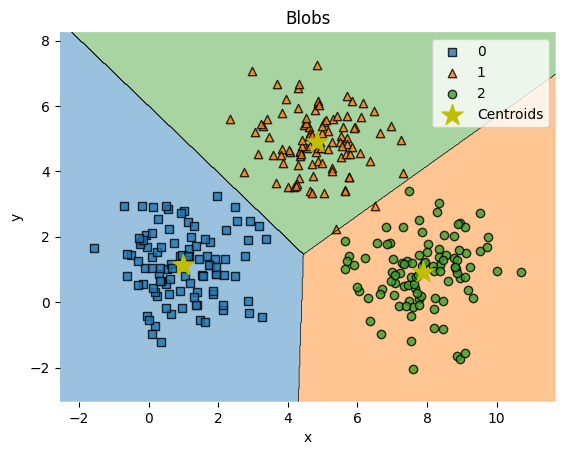

In [ ]:
# library for visualization 
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

clf = KMeans(3, None).fit(X,y)
df['Cluster label'] = clf.predict(df.iloc[:,:2]).astype(str)


plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250, label='Centroids')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Blobs')
plt.show()

## Visualize with Plotly

In [13]:
fig = px.scatter(df, x='Feature 1', y='Feature 2', color='Cluster label',
                 color_continuous_scale=["red","green", "blue"],
                 title='Labeled Data', marginal_x="histogram", marginal_y="histogram")
fig.add_scatter(x= clf.centers[:,0], y=clf.centers[:,1],mode='markers',marker=dict(size=20, symbol="x", color='black'), name='Centroid')
fig.show()

## 2. K-Means++

This algorithm is made to solve the problem of initial centroids values.

K-means++
1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute $D(x)$.
3. Choose the next centroid using a weighted probability distribution where a point x is chosen with probability proportional to  $𝐷(𝑥)^2$ .
4. Repeat until you have k points.

$D(x)$: the distance betweem x and the closest center

-----
Task: Implement K-means++ algorithm for selecting the intial points.

In [14]:
X.shape[0]
X[1]

array([6.95591231, 5.39009332])

In [ ]:
from numpy.random import choice


# cause we need to choose first center randomly
def choose(X, prob):
    # Return one point of X chosen randomly with probablity p
    # USE choise function in np.random (3 lines):
    n = X.shape[0]
    indx = choice(n, size=1, p = prob)
    return X[indx]

def kmeans_pp(X, k):
    n = X.shape[0]
    weights = np.ones(n) / n
    centers = []
    while len(centers) < k:
        # Choose a centroid with the current weights
        centroid = choose(X, weights)
        centers.extend(centroid)
        # TODO :
        # Calculate the pair-wise distances
        # between the datapoints X and the current centers
        # get min distance then square it.
        # Obtain new probabilities in weights.
        
        distances = cdist(X,centers)
        min_dist = np.min(distances, axis=1)
        d_squared = min_dist ** 2
        weights = d_squared / d_squared.sum()
 
    return np.array(centers)

initial_centers = kmeans_pp(X, 3)

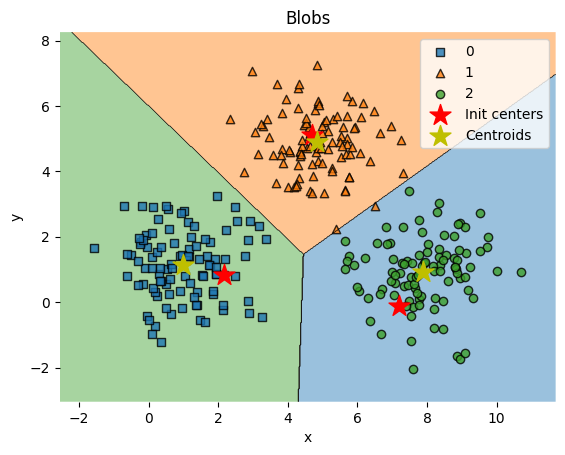

In [16]:
clf = KMeans(3, initial_centers).fit(X,y)

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='*', c='r', s=250,label='Init centers')
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Blobs')
plt.show()

## 3. How to choose k

### 3.1 Elbow method:

One way is to plot the sum of squared distances of samples to their centeriods vs number of clusters K.
Then, choose the K which the error doesn't decrease too much after.

In [17]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])

fig = px.scatter(df, x='Feature 1', y='Feature 2', marginal_x="histogram", marginal_y="histogram",
                 color_continuous_scale=["red","green", "blue"],
                 title='My unlabeled data')
fig.show()

In [18]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig = px.line(y=wcss, x=range(1, 11), title='Elbow Method',  markers=True)
fig.update_layout(title="Elbow Method", xaxis_title="Number of clusters", yaxis_title="WCSS")
fig.show()

Another way is to measure the silhouette score for the clustering.
This score measures the separability between clusters and the cohesion inside the clusters.

Then, we take the K that has higher score.

## 2.2 Silhouette Score

In [20]:
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    y = kmeans.predict(X)
    score = silhouette_score(X, y)
    silhouettes.append(score)


fig = px.line(y=silhouettes, x=range(2, 11), markers=True)
fig.update_layout(title="Silhouette Method", xaxis_title="Number of clusters", yaxis_title="silhouette score")
fig.show()

**We have to take number of cluster with a highest score** <br> In this case we are applying `Silhouette method`. The perfomance will be in range **[-1;1]**. This method show to us how close each point in our cluster to points in heighboring clusters. And it means that if we will get high value of silhouette score it means that we are really far from neghboring cluster.



In [21]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

fig = px.scatter(df, x='Feature 1', y='Feature 2',
                 title='Labeled Data')
fig.add_scatter(x= kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],mode='markers', marker=dict(size=20, symbol="x", color='red'),name='Centroid')
fig.show()

## Self practice task

  

Using [UNSW-NB15 Dataset](https://www.dropbox.com/s/nsvgwps3abdoxnq/clustering_data.zip?dl=1):

1. Preprocess the dataset
2. Reduce dimension using PCA
3. Remove outliers
4. Cluster the data using K-means (find the optimal number of k)
5. Visualize the data clusters (use PCA with 2 components)

In [1]:
from numpy.random import choice
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy
from sklearn.datasets import make_blobs
import pandas as pd
import plotly.express as px

We've already downloaded our data. And we have 2 files: `trainset.scv` and `testset.scv`. Our goal is to convert data to dataframe and preprocess it.


In [2]:
train_df = pd.read_csv('trainset.csv')
test_df = pd.read_csv('testset.csv')
print(f"Train shape: {train_df.shape}\nTest shape: {test_df.shape}")

Train shape: (175341, 42)
Test shape: (82332, 42)


Cause it task of unsupervised learning we don't actually need train and test sets. It means we can combine them together in one dataframe.


In [3]:
df = pd.concat([train_df, test_df])
print(f"Shape of our dataframe: {df.shape}")

Shape of our dataframe: (257673, 42)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  dinpkt  

Here we can clearly see that we dont have any missing data. But we have 3 features with object's type. Lets look at them carefully

In [5]:
df[['proto', 'service', 'state']].head(10)

,proto,service,state
0,tcp,-,FIN
1,tcp,-,FIN
2,tcp,-,FIN
3,tcp,ftp,FIN
4,tcp,-,FIN
5,tcp,-,FIN
6,tcp,-,FIN
7,tcp,-,FIN
8,tcp,-,FIN
9,tcp,-,FIN


Let's check number of uneqie values in our dataframe

In [6]:
object_features = ['proto', 'service', 'state']

for column in object_features:
    print(f"{column}: {df[column].nunique()} unique values")

proto: 133 unique values
service: 13 unique values
state: 11 unique values


Now we can see that we have 133 unique values in `proto` column. And it means that we can apply different encoder to get better perfomance. Now we need to apply encoding to our object data and we need standardize our numerical data. <br> For features with 13 and 11 unique values I will apply One-Hot encoding cause it won't create to many new columns and it make sense to apply it. For feature with 133 unique values I will apply **Target encoding technic** if we have task on supervised learning, but we are dealing here with unsupervised lerarning that is why we can apply `"Frequency Encoding"`. But to be Honest it will be much more easier to remove this feature if not impact on our result so much 



In [7]:
# let's implement our frequency encoding function 
def frequency_encoder(df, column_name, drop_original = True):
    # applying frequency encoding here 
    frequency_map = df[column_name].value_counts(normalize = True).to_dict()
    df[f"{column_name}_encoded"] = df[column_name].map(frequency_map)

    # if True drop original column with object data in our case  
    if drop_original == True:
        df = df.drop(columns=[column_name])
    return df


In [8]:
df = frequency_encoder(df=df, column_name='proto', drop_original=True)
print(df.shape)

(257673, 42)


In [9]:
from category_encoders import OneHotEncoder

categorical_features = ['service', 'state']
encoder = OneHotEncoder(cols = categorical_features, handle_unknown='ignore')

df_encoded = encoder.fit_transform(df)
new_columns = encoder.get_feature_names_out(categorical_features)
df = pd.DataFrame(df_encoded, columns= new_columns)

print(df.shape)

(257673, 64)


In [10]:
df.head()

,dur,service_1,service_2,service_3,service_4,service_5,service_6,service_7,service_8,service_9,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_encoded
0,0.121478,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,1,1,0,0.477508
1,0.649902,1,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,6,0,0.477508
2,1.623129,1,0,0,0,0,0,0,0,0,...,1,1,3,0,0,0,2,6,0,0.477508
3,1.681642,0,1,0,0,0,0,0,0,0,...,1,1,3,1,1,0,2,1,0,0.477508
4,0.449454,1,0,0,0,0,0,0,0,0,...,2,1,40,0,0,0,2,39,0,0.477508


Congrats!!! We've successfully figured out with categorical features

In [11]:
df.columns

Index(['dur', 'service_1', 'service_2', 'service_3', 'service_4', 'service_5',
       'service_6', 'service_7', 'service_8', 'service_9', 'service_10',
       'service_11', 'service_12', 'service_13', 'state_1', 'state_2',
       'state_3', 'state_4', 'state_5', 'state_6', 'state_7', 'state_8',
       'state_9', 'state_10', 'state_11', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'proto_encoded'],
      dtype='object')

Let's normalize our numerical data. I will apply Z-score normalization

In [12]:
from sklearn.preprocessing import StandardScaler

# columns that were created with One Hot Encoding 
one_hot_columns = ['service_1','service_2','service_3','service_4','service_5','service_6','service_7','service_8','service_9',
                   'service_10','service_11','service_12','service_13',
                   'state_1','state_2','state_3','state_4','state_5','state_6','state_7','state_8','state_9','state_10','state_11']

num_colums = df.select_dtypes(include=['float64', 'int64']).columns.difference(one_hot_columns)

scaler = StandardScaler()

df[num_colums] = scaler.fit_transform(df[num_colums])

df.head()

,dur,service_1,service_2,service_3,service_4,service_5,service_6,service_7,service_8,service_9,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,proto_encoded
0,-0.188346,1,0,0,0,0,0,0,0,0,...,-0.519345,-0.520051,-0.658496,-0.110419,-0.110372,-0.193597,-0.690790,-0.746782,-0.120335,0.734167
1,-0.099897,1,0,0,0,0,0,0,0,0,...,-0.519345,-0.520051,-0.568574,-0.110419,-0.110372,-0.193597,-0.690790,-0.287000,-0.120335,0.734167
2,0.063006,1,0,0,0,0,0,0,0,0,...,-0.519345,-0.520051,-0.478652,-0.110419,-0.110372,-0.193597,-0.571689,-0.287000,-0.120335,0.734167
3,0.072800,0,1,0,0,0,0,0,0,0,...,-0.519345,-0.520051,-0.478652,8.503550,8.479151,-0.193597,-0.571689,-0.746782,-0.120335,0.734167
4,-0.133449,1,0,0,0,0,0,0,0,0,...,-0.396808,-0.520051,2.848467,-0.110419,-0.110372,-0.193597,-0.571689,2.747558,-0.120335,0.734167


We've done with the 1st part of our processing data. Let's save it to csv file. Let's call him `processed_1.csv`. After applying PCA and removing outliers I will save changes again to a final file. <br> We are saving it now cause probably in the future when we will experement with PCA or some other technic we will need to return on this step (I mean to this file)


In [13]:
df.to_csv('processed_1.csv')

Let's download our data to processed_df


In [14]:
processed_df = pd.read_csv("processed_1.csv")

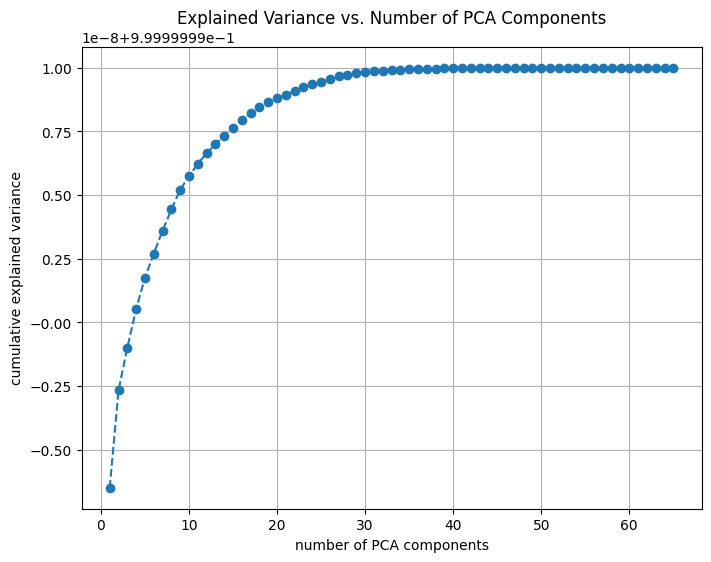

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
pca.fit(processed_df)

# Plot the cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.xlabel("number of PCA components")
plt.ylabel("cumulative explained variance")
plt.title("Explained Variance vs. Number of PCA Components")
plt.grid(True)
plt.show()

According to this plot I want to choose `n_components = 27`

In [31]:
pca_27 = PCA(n_components=27)

projected_features = pca_27.fit_transform(processed_df)

projected_features_df = pd.DataFrame(projected_features)

print(f"Shape of the processed df: {projected_features_df.shape}")

Shape of the processed df: (257673, 27)


Let's save our `projected_features_df` to csv file. 

In [27]:
projected_features_df.to_csv('projected_features.csv')

We have made basic preprocessing. Now we need to defind the optimal number of K and finally we will be ready to K-means clustering. 

I will apply two different types of scores to defind the best number of clusters:
1. Elbow method (sum of squared distances of samples to their centeroids VS number of clusters K) **Our goal in this method is to find a point from where decreasing  became not so crucial**
2. Silhouetta Score (It shows us how close each point in our cluster to points in neighboring clusters) **Here we have to take point with the hieghst result couse it will corrrespond that we are far from other clusters.**

In [ ]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(projected_features_df)
    # function .inertia_ return distabce I've discribed above in markdown
    wcss.append(kmeans.inertia_)

fig = px.line(y=wcss, x = range(1,30), title='Elbow Method', markers=True)
fig.update_layout(title = 'Elbow Method', xaxis_title = 'NUmber of Clusters', yaxis_title = 'WSCC')

fig.show()

I'll resample my data cause to calculate silhuetta score for our data takes to much time, I will use just 30% of all data

In [40]:
from sklearn.metrics import silhouette_score
from sklearn.utils import resample


df_sample = resample(projected_features_df, n_samples=int(len(projected_features_df) * 0.3), random_state=42)

silhouettes = []

for i in range(2, 15):
    kmeans_1 = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init = 'auto', random_state=0)
    kmeans_1.fit(df_sample)
    y = kmeans_1.predict(df_sample)

    score = silhouette_score(df_sample, y)
    silhouettes.append(score)

fig_1 = px.line(y = silhouettes, x = range(2,15), title='Silhouette Method', markers=True)
fig_1.update_layout(title = 'Silhouette Method', xaxis_title = 'Number of Clusters', yaxis_title = 'Silhouette Score' )

fig_1.show()
   

Let's implement function to plot our result 2D clusters for different number of clusters

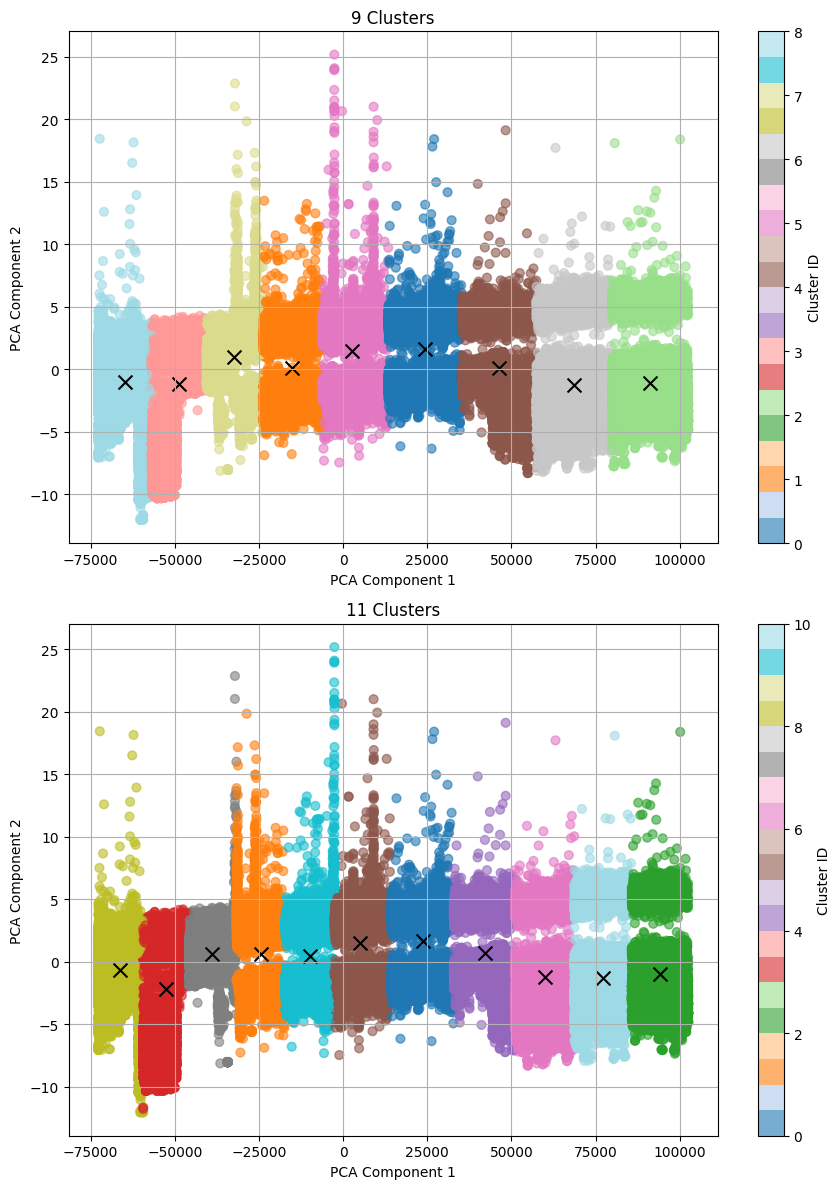

In [41]:
# Function to plot 2D clusters for different numbers of clusters
def plot_clusters_2d(features_scaled, cluster_sizes):
    fig, axes = plt.subplots(
        len(cluster_sizes), 1, figsize=(9, 12)
    )  # Vertical arrangement

    for i, n_clusters in enumerate(cluster_sizes):
        # 1. Perform PCA to reduce the features to 2D
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features_scaled)

        # 2. Fit KMeans with the specified number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_features)

        # 3. Plot the 2D scatter plot for the current number of clusters
        scatter = axes[i].scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            c=cluster_labels,
            cmap="tab20",  # Changed colormap for better color distinction
            s=40,  # Adjusted marker size
            alpha=0.6,  # Adjusted opacity for better overlap handling
        )
        
        # 4. Plot the cluster centers
        centers = kmeans.cluster_centers_
        axes[i].scatter(
            centers[:, 0],
            centers[:, 1],
            c="black",  # Cluster centers in black
            marker="x",
            s=100,
            label="Cluster Centers"
        )

        axes[i].set_title(f"{n_clusters} Clusters")
        axes[i].set_xlabel("PCA Component 1")
        axes[i].set_ylabel("PCA Component 2")
        axes[i].grid(True)

        # Add color legend for cluster labels
        fig.colorbar(scatter, ax=axes[i], orientation='vertical', label="Cluster ID")

    plt.tight_layout()
    plt.show()


# Define the cluster sizes for which you want to visualize the clusters
cluster_sizes = [9, 11]

# Assuming features_scaled is your feature matrix
plot_clusters_2d(projected_features_df, cluster_sizes)